In [1]:
import scanpy as sc
import logging

import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import Colormap, TwoSlopeNorm
import progeny
import dorothea

sc.set_figure_params(figsize=(4, 4))

In [2]:
adata = sc.read_h5ad(
    "../../data/20_annotate_all_cells/primary-tumor-annotated-integrated.h5ad"
)

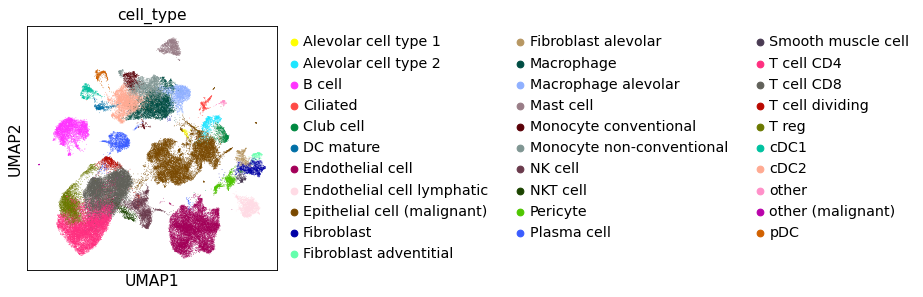

In [3]:
sc.pl.umap(adata, color=["cell_type"])

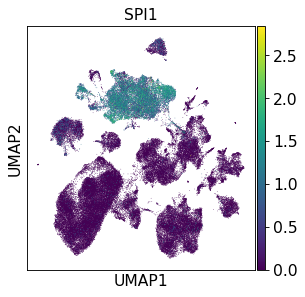

In [4]:
sc.pl.umap(adata, color=["SPI1"])

### Run progeny

In [5]:
model = progeny.getModel(organism="Human", top=1000)

In [6]:
progeny.run(adata, model, center=False, scale=True)

8203 genes found


In [7]:
adata.obsm["progeny"].columns = [f"PW:{pw}" for pw in adata.obsm["progeny"].columns]

In [8]:
pathways_of_interest = [
    f"PW:{x}" for x in ["JAK-STAT", "VEGF", "PI3K", "NFkB", "Trail", "TNFa"]
]

In [9]:
adata.obs = adata.obs.join(
    adata.obsm["progeny"].loc[:, pathways_of_interest]
)

In [10]:
adata

AnnData object with n_obs × n_vars = 86061 × 17567
    obs: 'sample', 'patient', 'tissue', 'origin', 'condition', 'dataset', 'sex', 'cell_type', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'cell_type_predicted', 'cnv_leiden', 'cnv_score', 'leiden', 'is_malignant', 'cell_type_coarse', 'PW:JAK-STAT', 'PW:VEGF', 'PW:PI3K', 'PW:NFkB', 'PW:Trail', 'PW:TNFa'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: '_scvi', 'cell_type_coarse_colors', 'cell_type_colors', 'cell_type_predicted_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'hvg', 'is_malignant_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scANVI', 'X_umap', 'progeny'
    layers: 'raw_counts'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

### Run dorothea

In [11]:
regulons = dorothea.load_regulons(
    [
        "A",
        "B",
    ],  # Which levels of confidence to use (A most confident, E least confident)
    organism="Human",  # If working with mouse, set to Mouse
)

In [12]:
dorothea.run(
    adata,
    regulons,
    center=True,  # Center gene expression by mean per cell
    num_perm=100,  # Simulate m random activities
    norm=True,  # Normalize by number of edges to correct for large regulons
    scale=True,  # Scale values per feature so that values can be compared across cells
    min_size=5,  # TF with less than 5 targets will be ignored
)

3075 targets found


100%|██████████| 100/100 [08:53<00:00,  5.33s/it]


In [13]:
adata.obsm["dorothea"].columns = [f"TF:{tf}" for tf in adata.obsm["dorothea"].columns]

In [14]:
tfs_of_interest = [
    f"TF:{tf}" for tf in ["SPI1", "NFKB1", "STAT1", "MYC", "E2F4", "E2F2", "ZNF263"]
]

In [15]:
adata.obs = adata.obs.join(adata.obsm["dorothea"].loc[:, tfs_of_interest])

In [16]:
adata

AnnData object with n_obs × n_vars = 86061 × 17567
    obs: 'sample', 'patient', 'tissue', 'origin', 'condition', 'dataset', 'sex', 'cell_type', 'batch', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'cell_type_predicted', 'cnv_leiden', 'cnv_score', 'leiden', 'is_malignant', 'cell_type_coarse', 'PW:JAK-STAT', 'PW:VEGF', 'PW:PI3K', 'PW:NFkB', 'PW:Trail', 'PW:TNFa', 'TF:SPI1', 'TF:NFKB1', 'TF:STAT1', 'TF:MYC', 'TF:E2F4', 'TF:E2F2', 'TF:ZNF263'
    var: 'chromosome', 'start', 'end', 'gene_id', 'gene_name'
    uns: '_scvi', 'cell_type_coarse_colors', 'cell_type_colors', 'cell_type_predicted_colors', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'hvg', 'is_malignant_colors', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_scANVI', 'X_umap', 'progeny', 'dorothea'
    layers: 'raw_counts'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

## Export adata

In [17]:
adata.write_h5ad(
    "../../data/40_dorothea_progeny/40_primary_tumor_dorothea_progeny.h5ad",
    compression="lzf",
)

## Visualize
### Transcription factors

In [18]:
# fake adata object for stacked violin
dorothea_df = adata.obsm["dorothea"]
tmp_adata = sc.AnnData(X=dorothea_df.values.copy(), obs=adata.obs.loc[:, ["cell_type"]])
tmp_adata.var_names = dorothea_df.columns

In [19]:
sc.pp.scale(tmp_adata)

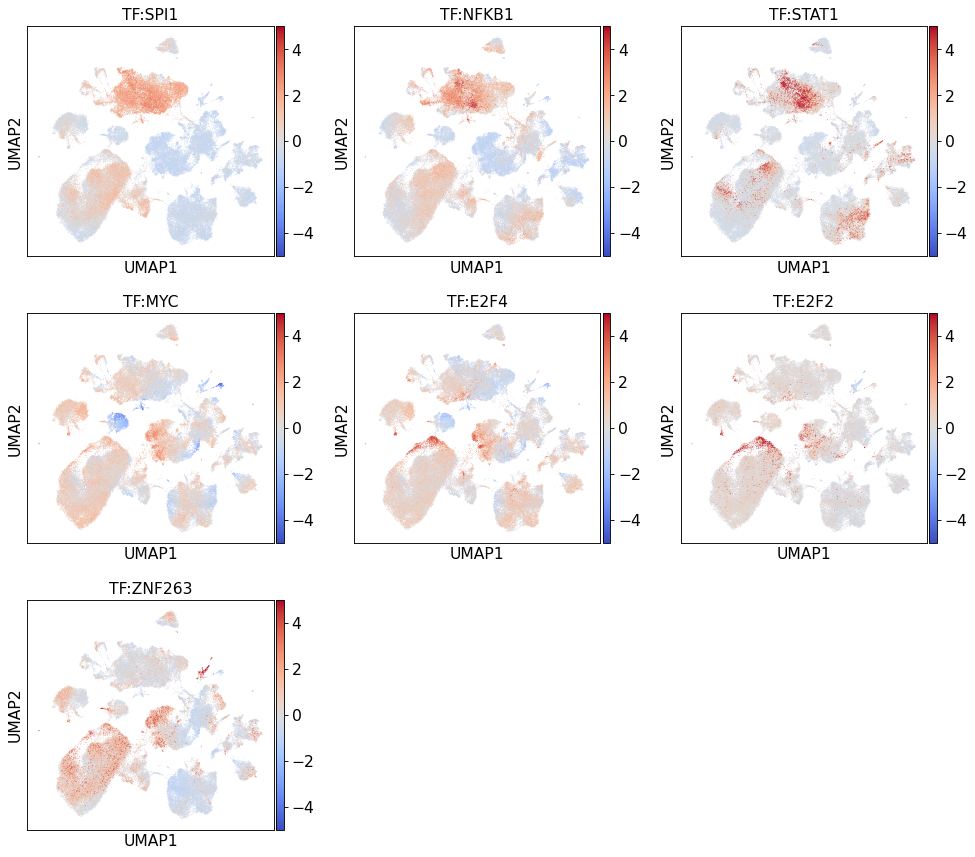

In [20]:
norm = TwoSlopeNorm(0, vmin=-5, vmax=5)
sc.pl.umap(adata, color=tfs_of_interest, ncols=3, cmap="coolwarm", norm=norm)

         Falling back to preprocessing with `sc.pp.pca` and default params.


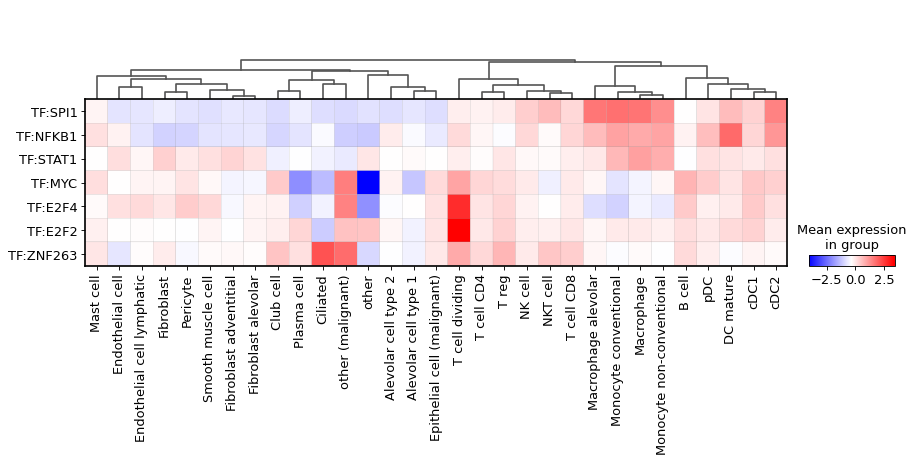

In [21]:
sc.pl.matrixplot(
    tmp_adata,
    groupby="cell_type",
    var_names=tfs_of_interest,
    swap_axes=True,
    dendrogram=True,
    cmap="bwr",
)

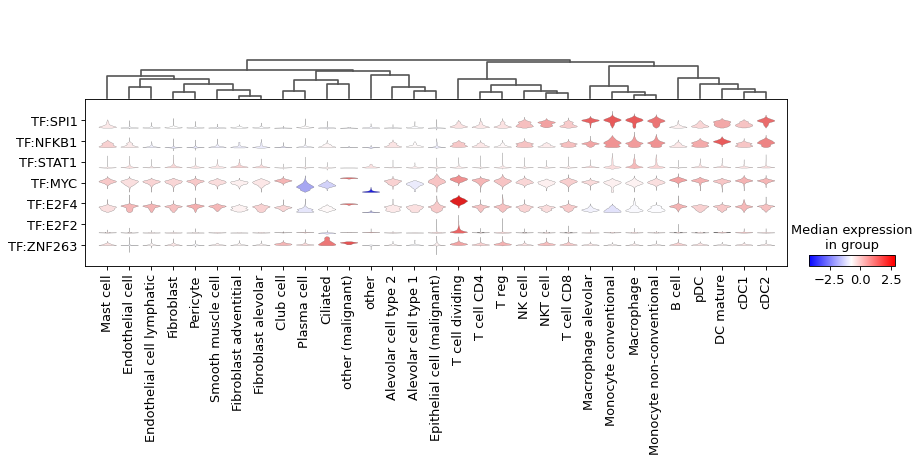

In [22]:
sc.pl.stacked_violin(
    tmp_adata,
    groupby="cell_type",
    var_names=tfs_of_interest,
    swap_axes=True,
    dendrogram=True,
    cmap="bwr",
)

### Pathways

In [23]:
# fake adata object for stacked violin
progeny_df = adata.obsm["progeny"]
tmp_adata = sc.AnnData(
    X=progeny_df.values.copy(), obs=adata.obs.loc[:, ["cell_type"]], obsm=adata.obsm
)
tmp_adata.var_names = progeny_df.columns

In [24]:
sc.pp.scale(tmp_adata)

In [25]:
pathways_of_interest

['PW:JAK-STAT', 'PW:VEGF', 'PW:PI3K', 'PW:NFkB', 'PW:Trail', 'PW:TNFa']

In [26]:
progeny_df.loc[:, "PW:JAK-STAT"]

SRR10783827-0    1.842312
SRR10786816-0   -0.968076
SRR10789406-0   -0.047932
SRR10782305-0    0.036031
SRR10796949-0    3.727960
                   ...   
6440-6          -0.168905
6441-6           0.095130
6443-6          -0.060745
6444-6           0.084917
6445-6          -0.001444
Name: PW:JAK-STAT, Length: 86061, dtype: float64

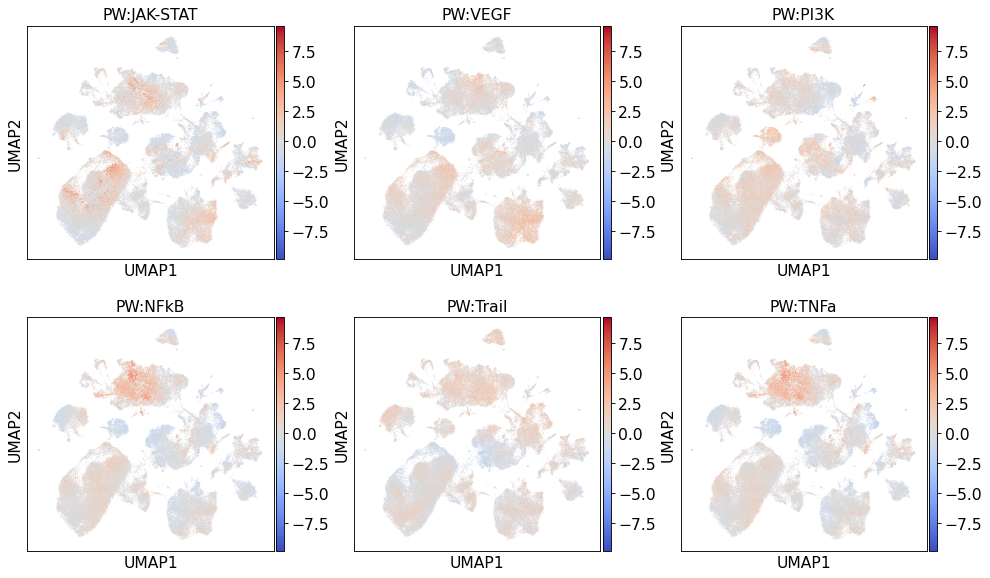

In [27]:
norm = TwoSlopeNorm(0, vmin=np.min(tmp_adata.X), vmax=np.max(tmp_adata.X))
sc.pl.umap(tmp_adata, color=pathways_of_interest, ncols=3, norm=norm, cmap="coolwarm")

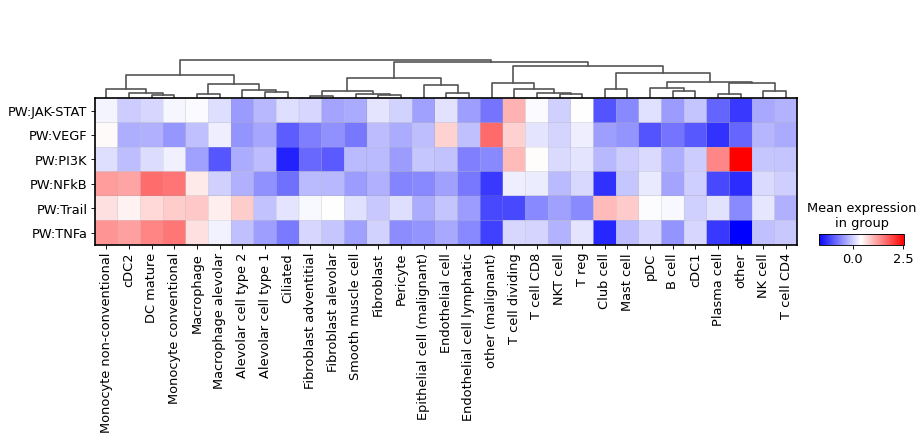

In [28]:
sc.pl.matrixplot(
    tmp_adata,
    groupby="cell_type",
    var_names=pathways_of_interest,
    swap_axes=True,
    dendrogram=True,
    cmap="bwr",
)

         Falling back to preprocessing with `sc.pp.pca` and default params.


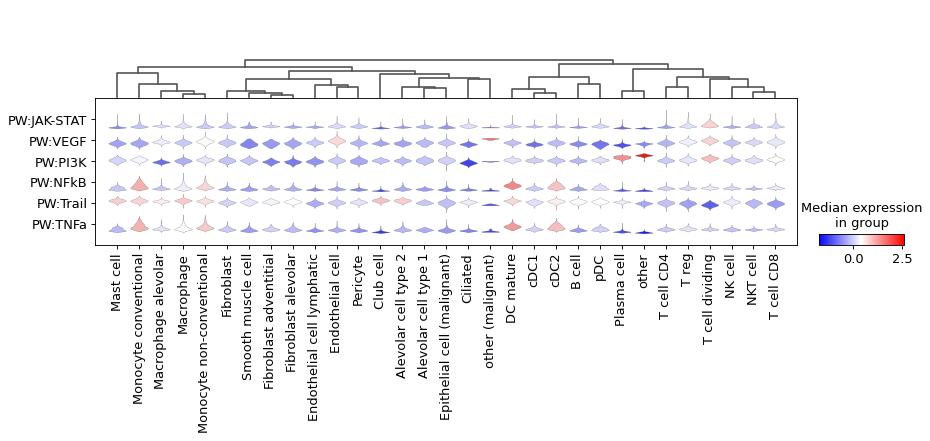

In [29]:
sc.pl.stacked_violin(
    adata,
    groupby="cell_type",
    var_names=pathways_of_interest,
    swap_axes=True,
    dendrogram=True,
    cmap="bwr",
)

### Genes

In [30]:
genes_of_interest = regulons.index[regulons["SPI1"] != 0]

In [31]:
genes_of_interest = list(genes_of_interest) + ["TREM2", "SPI1"]

In [32]:
genes_of_interest = list(set(genes_of_interest) & set(adata.var_names.values))

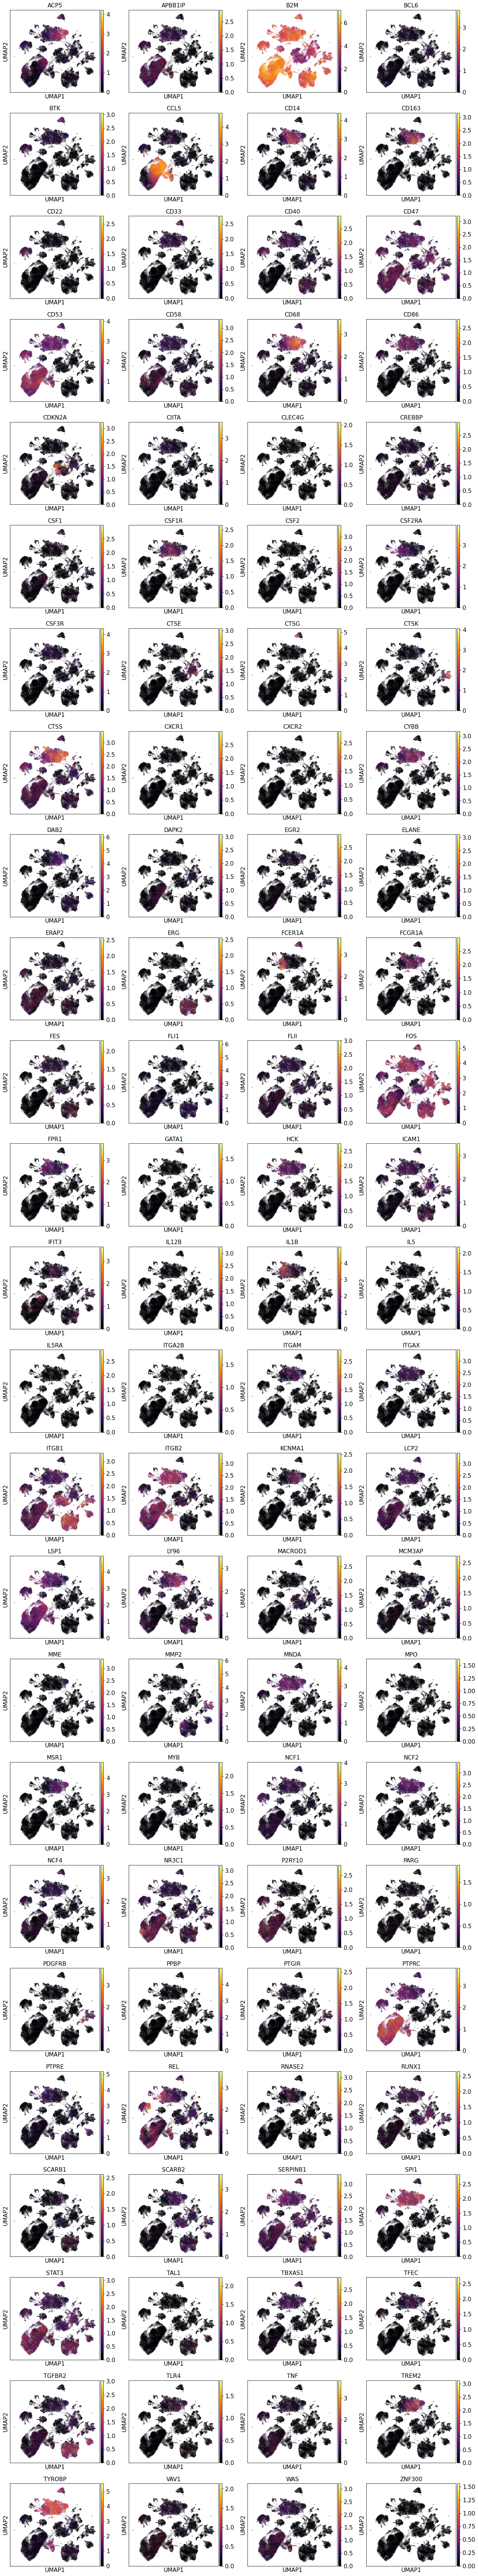

In [33]:
sc.pl.umap(adata, color=sorted(genes_of_interest), cmap="inferno")

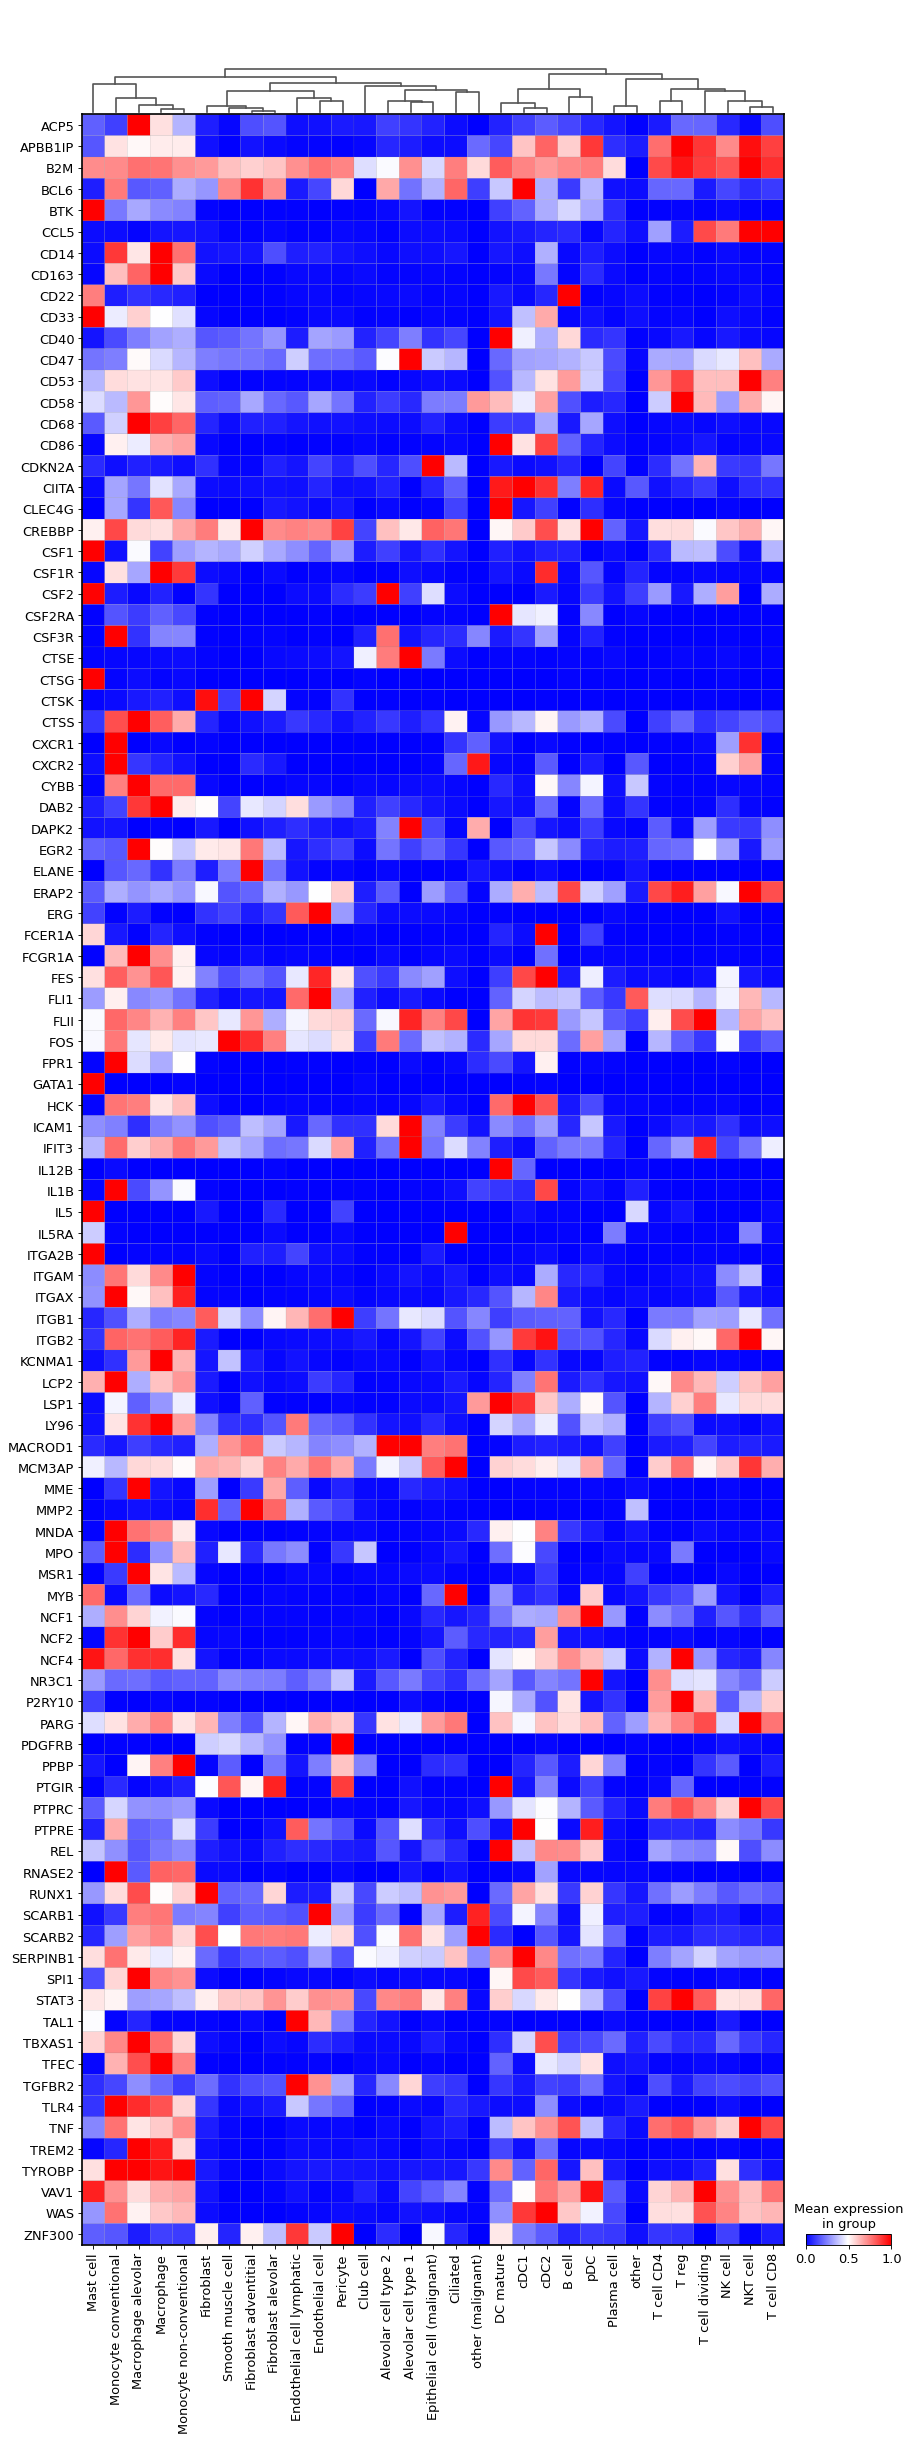

In [34]:
sc.pl.matrixplot(
    adata,
    groupby="cell_type",
    var_names=sorted(genes_of_interest),
    swap_axes=True,
    dendrogram=True,
    cmap="bwr",
    standard_scale="var",
)